__автоэнкодер__  

Евгений Борисов  <esborisov@sevsu.ru>

----

сжимаем  картинку MNIST из размера [28x28] в [2] и обратно из [2] в [28x28]  

https://github.com/YunYang1994/TensorFlow2.0-Examples/blob/master/3-Neural_Network_Architecture/autoencoder.py

http://www.cs.toronto.edu/~hinton/science.pdf

# загружаем данные

In [1]:
# !pip install torchvision

In [2]:
import torch

# import torchvision
from torchvision.datasets import MNIST
# from torchvision.datasets import FashionMNIST as MNIST
# from torch.utils.data import DataLoader
from torchvision import transforms

In [3]:
transform  = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((.5),(.5)) ])
ds_train = MNIST(root='./data', train=True,  download=True, transform=transform)
ds_test  = MNIST(root='./data', train=False, download=True, transform=transform)
#ds_train  = MNIST(root='./data', train=False, download=True, transform=transform)

target_names = ds_train.classes
n_classes = len(target_names)

display(ds_train.data.shape)
display(n_classes)

torch.Size([60000, 28, 28])

10

In [4]:
# ds_train[0]

In [5]:
from tqdm.auto import tqdm
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

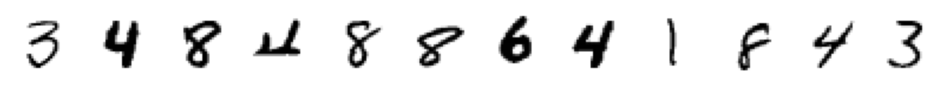

In [6]:
n_show = 12
n_samples = ds_train.data.shape[0]
fig,ax = plt.subplots(1,n_show,figsize=(12,3))
for n,i in enumerate(rng.permutation(n_samples)[:n_show]):
    ax[n].imshow(ds_train.data[i],cmap='gray_r')
    #ax[n].set_title(target_names[ ds_train.targets[i]],color='b',fontsize=9)
    ax[n].axis('off')

# модель

Implementing an Autoencoder in PyTorch.    
https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch

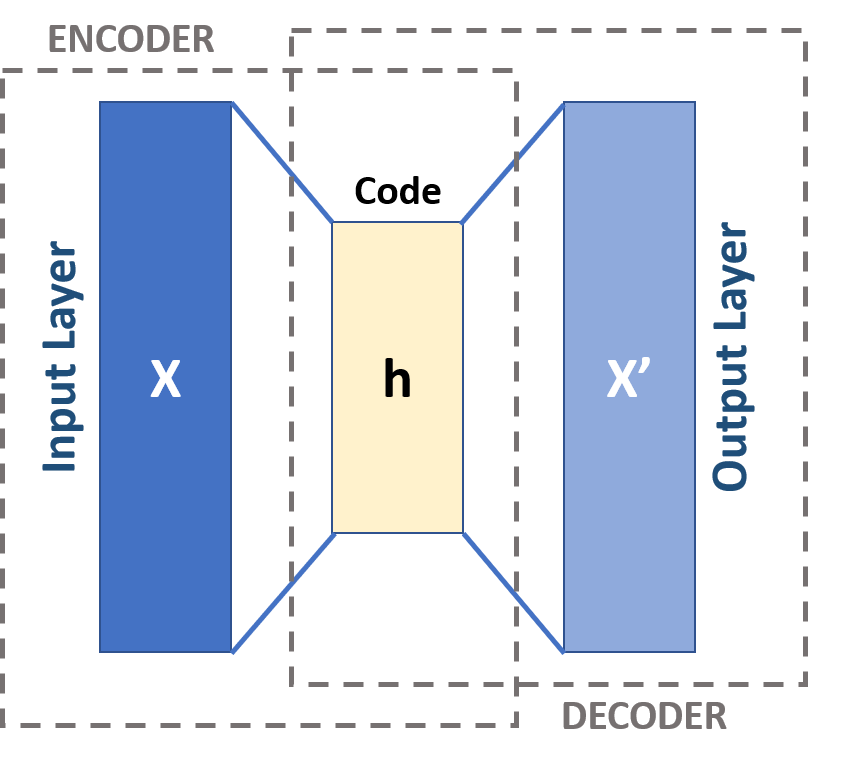

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class AE(nn.Module):
    def __init__(self,in_size=28*28):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            nn.Linear(in_size, 128), nn.ReLU(),
            nn.Linear(128, 32),      nn.ReLU(),
            nn.Linear(32,   2),  
        )
         
        self.decoder = torch.nn.Sequential(
            nn.Linear(2,  32 ),      nn.ReLU(),
            nn.Linear(32, 128),      nn.ReLU(),
            nn.Linear(128, in_size), nn.Tanh(),
        )
 
    def forward(self, x):
        o = self.encoder(x)
        o = self.decoder(o)
        return o

In [11]:
model = AE(in_size=28*28)

In [ ]:
# from torch.utils.data import DataLoader
# for x,_ in DataLoader( ds_train, batch_size=3, shuffle=True): break

# display(x.shape)
# bs,c,h,w = x.shape
# x_ = x.reshape(bs,h*w*c)
# display(x_.shape)

# with torch.set_grad_enabled(False):
#     o = model(x_)

# display(o.shape)

# обучаем модель

In [12]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [13]:
model = model.to(device)

# ф-ция потери
criterion =  nn.MSELoss()

# метод оптимизации
optimizer = torch.optim.Adam( model.parameters(), lr=1e-3) 
# optimizer = torch.optim.Adam(model.parameters(),  lr = 1e-6, weight_decay = 1e-8)

----

In [14]:
from torch.utils.data import DataLoader

loss_history = [] # значения ф-ции потери
# acc_history = []

from tqdm.auto import tqdm
# from sklearn.metrics import accuracy_score

In [15]:
%%time

n_epoch = 16*4 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    loss_batch = []

    # получаем батч учебных примеров
    for x,_ in DataLoader( ds_train, batch_size=256, 
                          shuffle=True, num_workers=4, pin_memory=True): 
        bs,c,h,w = x.shape
        x_ = x.view(-1,h*w*c).to(device)
        loss = criterion( model.forward(x_), x_ ) # вычисляем значение ф-ции потери
        loss_batch.append( loss.item() ) # дополняем историю изменения значений ф-ции потери на батче
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
    
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
    
#     if i % 1000 == 0:
#         print("=> %4d loss %.4f" %(step, loss))
#         pred_image = model(sample, training=False)
#         pred_image = np.reshape(pred_image, (n_samples, 28, 28))
#         show_image = np.concatenate(pred_image[:n_samples], -1)
#         plt.figure(figsize=(n_samples*3,3))
#         plt.axis(False)
#         plt.imshow(show_image)
##         plt.savefig('aenc/%05d.png'%(step))

  0%|          | 0/64 [00:00<?, ?it/s]

CPU times: user 40.6 s, sys: 6.88 s, total: 47.5 s
Wall time: 1min 57s


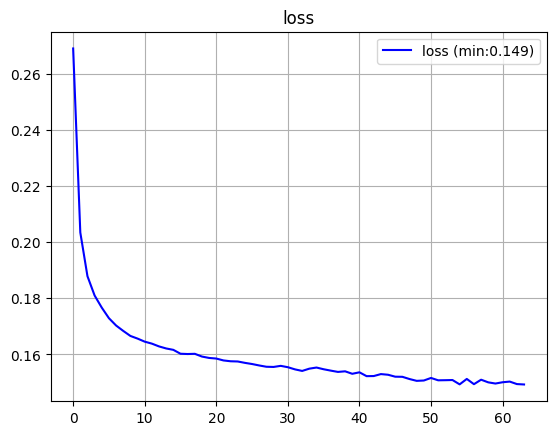

In [16]:
# история изменения значений погрешности модели
fig,ax = plt.subplots()
ax.plot(loss_history,label=f'loss (min:{min(loss_history):.3f})',c='b' )
ax.grid()
ax.set_title('loss')
ax.legend()

## оценка результатов 

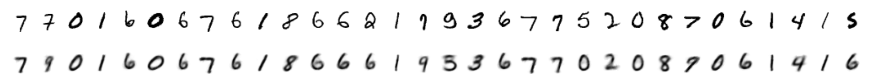

In [17]:
# from torch.utils.data import DataLoader

n_show = 32
with torch.set_grad_enabled(False):
    for x,t in DataLoader( ds_test, batch_size=n_show, shuffle=True): break
    bs,c,h,w = x.shape
    x_ = x.reshape(bs,h*w*c).to(device)
    o = model(x_).cpu()
    o = o.reshape(bs,h,w).numpy()
    x = x.squeeze().numpy()

x_ = ((x+1.)*127.).astype(np.uint8)
o_ = ((o - o.min())/(o.max()-o.min())*255. ).astype(np.uint8)

fig,ax = plt.subplots(2,n_show,figsize=(11,1))
for n in range(n_show):
    ax[0,n].imshow(x_[n],cmap='gray_r')
    ax[0,n].axis('off')
    ax[1,n].imshow(o_[n],cmap='gray_r')
    ax[1,n].axis('off')

---

In [18]:
encoder = model.encoder

In [19]:
from torch.utils.data import DataLoader

with torch.set_grad_enabled(False):
    for x,t in DataLoader( ds_test, batch_size=len(ds_test), shuffle=True): break
    bs,c,h,w = x.shape
    x_ = x.reshape(bs,h*w*c).to(device)
    o = encoder(x_).cpu()

display(o.shape)

torch.Size([10000, 2])

In [20]:
labels = t.numpy()
emb = o.numpy()

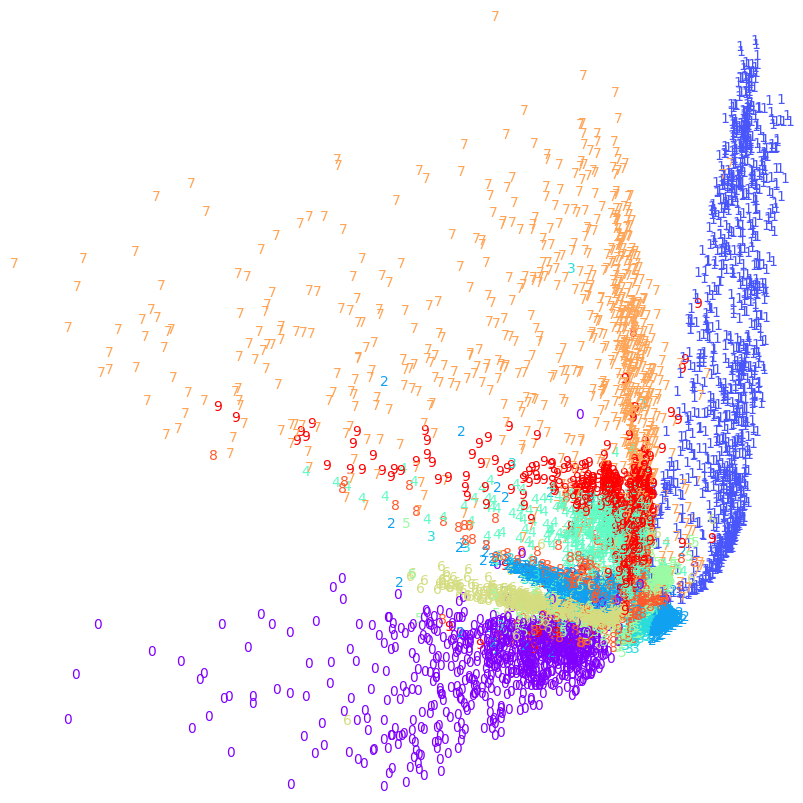

In [21]:
# рисуем результаты решения задачи понижения размерности из [28x28] в [2]
# представления на плоскости исходных картинок с помощью модели автоэнкодера

from matplotlib import cm

colors = { i:cm.rainbow(int((255*i)/9)) for i in range(10) }
X,Y = emb[:,0], emb[:,1]

fig,ax = plt.subplots(figsize=(10,10))
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
for x,y,l in zip(X,Y,labels): 
    ax.text(x, y, l, color=colors[l])
ax.axis('off')
plt.show()